In [ ]:
!pip install transformers wikipedia newspaper3k GoogleNews pyvis

In [ ]:
!pip install lxml[html_clean]


In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import wikipedia
from newspaper import Article, ArticleException
from GoogleNews import GoogleNews
import IPython
from pyvis.network import Network

In [57]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [58]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [59]:
class KB():
    def __init__(self):
        self.entities = {}
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def get_wikipedia_data(self, candidate_entity):
        try:
            page = wikipedia.page(candidate_entity, auto_suggest=False)
            entity_data = {
                "title": page.title,
                "url": page.url,
                "summary": page.summary
            }
            return entity_data
        except:
            return None

    def add_entity(self, e):
        self.entities[e["title"]] = {k:v for k,v in e.items() if k != "title"}

    def add_relation(self, r):
        # check on wikipedia
        candidate_entities = [r["head"], r["tail"]]
        entities = [self.get_wikipedia_data(ent) for ent in candidate_entities]

        # if one entity does not exist, stop
        if any(ent is None for ent in entities):
            return

        # manage new entities
        for e in entities:
            self.add_entity(e)

        # rename relation entities with their wikipedia titles
        r["head"] = entities[0]["title"]
        r["tail"] = entities[1]["title"]

        # manage new relation
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Entities:")
        for e in self.entities.items():
            print(f"  {e}")
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [60]:
def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) /
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 1024,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [6]:
import pandas as pd

df = pd.read_csv('/home/oi.temp-aswathi/train-root/data/processed/test_data.csv')

In [7]:
len(df.loc[df['Language'] == 'english'])

5920

In [8]:
text = df['Content'][1192]
text

'On 23 September, Bi Visibility Day is observed annually to honour and celebrate bisexual people, the bisexual community, and the history of bisexuality. The day is also referred to as Bisexual Pride Day, Bisexual Visibility Day, CBD, Bisexual Pride and Bi Visibility Day, and Bisexuality+ Day.Bi Visibility Day 2022: HistoryFounded in 1999, Celebrate Bisexuality Day or Bi Visibility Day was officially observed at the International Lesbian and Gay Association Conference in Johannesburg, South Africa. It is the brainchild of Wendy Curry from Maine, Michael Page from Florida, and Gigi Raven Wilbur from Texas.As opposed to LGBT events in general, this celebration of bisexuality was created in response to prejudice and marginalization against bisexual people in both the straight and LGBT communities .The Berkeley City Council unanimously and without discussion declared 23 September as Bisexual Pride and Bi Visibility Day on 18 September 2012, becoming what is believed to be the first city in

In [13]:
kb = from_text_to_kb(text, verbose=False)
kb.print()

Entities:
  ('Johannesburg', {'url': 'https://en.wikipedia.org/wiki/Johannesburg', 'summary': 'Johannesburg ( joh-HAN-iss-burg, US also  -\u2060HAHN-, Afrikaans: [jʊəˈɦanəsbœrχ]; Zulu and Xhosa: eGoli [ɛˈɡɔːli]) (colloquially known as Jozi, Joburg, Jo\'burg or "The City of Gold") is the most populous city in South Africa with 4,803,262 people in the City of Johannesburg alone. It is a conurbation engulfing many formerly separate cities and towns and is classified as a megacity. It is one of the 100 largest urban areas in the world. It is the provincial capital of Gauteng, the wealthiest province in South Africa. Johannesburg is the seat of the Constitutional Court, the highest court in South Africa. Most of the major South African companies and banks have their head offices in Johannesburg. The city is located within the mineral-rich Witwatersrand hills, the epicentre of the international-scale mineral and gold trade.\nJohannesburg was established in 1886, following the discovery of go

In [9]:
import pickle

def save_kb(kb, filename):
    with open(filename, "wb") as f:
        pickle.dump(kb, f)

def load_kb(filename):
    res = None
    with open(filename, "rb") as f:
        res = pickle.load(f)
    return res

## matplotlib

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph_with_pyplot(kb, fig_width=12, fig_height=8):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges from the relations
    for r in kb.relations:
        G.add_edge(r["head"], r["tail"], label=r["type"])

    # Define node positions (optional: can be randomized or calculated)
    pos = nx.spring_layout(G, k=0.5, seed=42)

    # Create the figure with specified size
    plt.figure(figsize=(fig_width, fig_height))

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color="lightgreen", node_size=700)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True)

    # Draw the labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(u, v): d["label"] for u, v, d in G.edges(data=True)}
    )

    # Configure plot appearance
    plt.title("Graph Visualization", fontsize=16)
    plt.axis("off")
    plt.show()


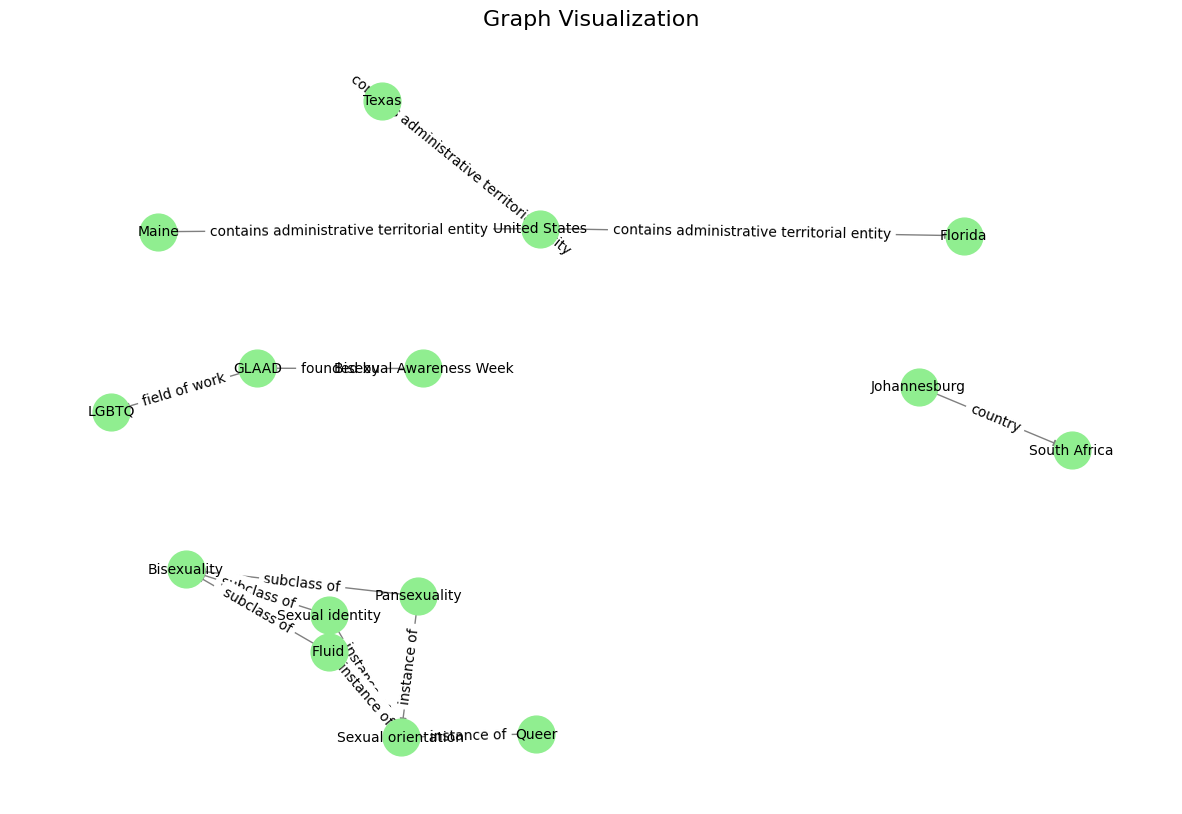

In [19]:
kb = from_text_to_kb(text, verbose=False)
filename = "test.html"
plot_graph_with_pyplot(kb, fig_width=15, fig_height=10)


## pyvis

In [10]:
from pyvis.network import Network
from IPython.display import IFrame

def save_network_html(kb, filename="network.html"):
    # Create network
    net = Network(directed=True, width="700px", height="700px", bgcolor="#eeeeee")

    # Define node color
    color_entity = "#00FF00"

    # Add nodes and edges
    for r in kb.relations:
        # Add nodes for the head and tail if not already added
        net.add_node(r["head"], shape="circle", color=color_entity)
        net.add_node(r["tail"], shape="circle", color=color_entity)

        # Add edge between the head and tail
        net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"])

    # Configure network
    net.repulsion(
        node_distance=200,
        central_gravity=0.2,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09
    )
    net.set_edge_smooth('dynamic')

    # Write to HTML
    net.write_html(filename)

    # # Display the HTML file in a notebook using IFrame
    # return IFrame(filename, width="800", height="800")


### for single file

In [12]:
kb = from_text_to_kb(text, verbose=False)
filename = "test.html"
save_network_html(kb, filename=filename)

### For multiple files

In [ ]:
# Extract relations from model output (optimized)
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, object_ = '', '', ''
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation:
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation:
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject and relation and object_:
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

# Optimized function to create knowledge base from text
def from_text_to_kb_batch(texts, span_length=128, verbose=False):
    kb = KB()
    for text in texts:
        # Tokenize whole text
        inputs = tokenizer([text], return_tensors="pt")

        # Compute span boundaries
        num_tokens = len(inputs["input_ids"][0])
        num_spans = math.ceil(num_tokens / span_length)
        overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
        spans_boundaries = []
        start = 0
        for i in range(num_spans):
            spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
            start -= overlap

        # Create tensor slices for spans
        tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

        # Generate relations
        gen_kwargs = {"max_length": 1024, "num_beams": 3, "num_return_sequences": 3}
        generated_tokens = model.generate(**inputs, **gen_kwargs)

        # Decode relations
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
        for i, sentence_pred in enumerate(decoded_preds):
            current_span_index = i // 3  # Adjust for the number of beams
            relations = extract_relations_from_model_output(sentence_pred)
            for relation in relations:
                relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
                kb.add_relation(relation)
    return kb

# Process contents between indices 1163 and 1184
def process_contents_range(df, start_idx, end_idx):
    texts = df['Content'][start_idx:end_idx].tolist()  # Extract the texts between the given range
    kb = from_text_to_kb_batch(texts, span_length=128, verbose=False)
    return kb

def save_network_html(kb, filename="network.html"):
    # Create network
    net = Network(directed=True, width="1280px", height="980px", bgcolor="#eeeeee")

    # Define color schemes
    entity_colors = {
        "Person": "#FF6347",  # Tomato Red for people
        "Location": "#1E90FF",  # Dodger Blue for locations
        "Organization": "#32CD32",  # Lime Green for organizations
        "Default": "#00FF00"  # Default Green for other entities
    }
    
    relation_colors = {
        "works_for": "#8A2BE2",  # BlueViolet for works_for relations
        "located_in": "#FFD700",  # Gold for located_in relations
        "has_relation_with": "#FF4500",  # OrangeRed for generic relations
        "Default": "#808080"  # Grey for other relations
    }

    # Add nodes and edges
    for r in kb.relations:
        # Set node colors based on the type of entity
        head_color = entity_colors.get(r["head"].split(" ")[0], entity_colors["Default"])  # First word of head as type
        tail_color = entity_colors.get(r["tail"].split(" ")[0], entity_colors["Default"])  # First word of tail as type
        
        # Add nodes for the head and tail if not already added
        net.add_node(r["head"], shape="circle", color=head_color, title=r["head"])
        net.add_node(r["tail"], shape="circle", color=tail_color, title=r["tail"])

        # Set edge color based on the relation type
        edge_color = relation_colors.get(r["type"], relation_colors["Default"])
        
        # Add edge between the head and tail
        net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"], color=edge_color)

    # Configure network
    net.repulsion(node_distance=200, central_gravity=0.2, spring_length=200, spring_strength=0.05, damping=0.09)
    net.set_edge_smooth('dynamic')

    # Write to HTML
    net.write_html(filename)

    # Display the HTML file in a notebook using IFrame
    return filename

# Load and process the content range 1163-1184
kb = process_contents_range(df, 1164, 1184)
filename = "combined_knowledge_graph.html"
save_network_html(kb, filename=filename)

print(f"Knowledge graph saved as {filename}")


*combine the articles* - **best working**

In [ ]:
# Extract relations from model output (optimized)
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, object_ = '', '', ''
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation:
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation:
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject and relation and object_:
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

# Optimized function to create knowledge base from text
def from_text_to_kb_batch(texts, span_length=128, verbose=False):
    kb = KB()
    for text in texts:
        # Tokenize whole text
        inputs = tokenizer([text], return_tensors="pt")

        # Compute span boundaries
        num_tokens = len(inputs["input_ids"][0])
        num_spans = math.ceil(num_tokens / span_length)
        overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
        spans_boundaries = []
        start = 0
        for i in range(num_spans):
            spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
            start -= overlap

        # Create tensor slices for spans
        tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

        # Generate relations
        gen_kwargs = {"max_length": 1024, "num_beams": 3, "num_return_sequences": 3}
        generated_tokens = model.generate(**inputs, **gen_kwargs)

        # Decode relations
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
        for i, sentence_pred in enumerate(decoded_preds):
            current_span_index = i // 3  # Adjust for the number of beams
            relations = extract_relations_from_model_output(sentence_pred)
            for relation in relations:
                relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
                kb.add_relation(relation)
    return kb

# Process contents between indices 1163 and 1184 into a single text
def process_contents_range(df, start_idx, end_idx):
    # Extract the texts between the given range and combine them into one single string
    text = " ".join(df['Content'][start_idx:end_idx].tolist())  # Join the list into a single string
    kb = from_text_to_kb_batch([text], span_length=128, verbose=True)  # Pass as a list with one text
    return kb

def save_network_html(kb, filename="network.html"):
    # Create network
    net = Network(directed=True, width="1280px", height="980px", bgcolor="#f7f7f7")

    # Define vibrant and interesting color schemes
    vibrant_colors = ["#FF6347", "#32CD32", "#1E90FF", "#FFD700", "#FF69B4", "#9370DB", "#00FA9A", "#FFA07A"]
    category_color = "#FFA500"  # Orange for category nodes
    default_entity_color = "#808080"  # Grey for default entities
    relation_color = "#B0C4DE"  # LightSteelBlue for edges

    # Add nodes and edges with vibrant colors
    for i, r in enumerate(kb.relations):
        # Assign a color from the vibrant color list in a cycle
        node_color = vibrant_colors[i % len(vibrant_colors)]

        # Add nodes for the head and tail if not already added
        net.add_node(r["head"], shape="circle", color="#9370DB", title=r["head"])
        net.add_node(r["tail"], shape="circle", color="#9370DB", title=r["tail"])

        # Add edge between the head and tail
        net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"], color=relation_color)

    # Configure network for a more interesting presentation
    net.repulsion(node_distance=150, central_gravity=0.2, spring_length=150, spring_strength=0.05, damping=0.09)
    net.set_edge_smooth('dynamic')

    # Write to HTML
    net.write_html(filename)

    # Return the filename
    return filename

# Load and process the content range 1163-1184
kb = process_contents_range(df, 1164, 1214)
filename = "combined_knowledge_graph_test2.html"
save_network_html(kb, filename=filename)

print(f"Knowledge graph saved as {filename}")


/home/oi.temp-aswathi/.venv/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/oi.temp-aswathi/.venv/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Knowledge graph saved as combined_knowledge_graph_test2.html


*making entities global* - not good

In [ ]:
# from collections import defaultdict

# # Function to track global entities and relations
# def update_global_entities(kb, global_entities):
#     """
#     Update the global entities with the new entities found in the knowledge base.
#     """
#     for r in kb.relations:
#         # Extract subject (head), relation type, and object (tail)
#         head, relation, tail = r["head"], r["type"], r["tail"]
        
#         # Check if the head already exists in the global entities, else add it
#         if head not in global_entities["entities"]:
#             global_entities["entities"][head] = {'relations': [], 'count': 0}
#         global_entities["entities"][head]['relations'].append(relation)
#         global_entities["entities"][head]['count'] += 1

#         # Check if the tail already exists in the global entities, else add it
#         if tail not in global_entities["entities"]:
#             global_entities["entities"][tail] = {'relations': [], 'count': 0}
#         global_entities["entities"][tail]['relations'].append(relation)
#         global_entities["entities"][tail]['count'] += 1

#         # Add the relation to the global relations list
#         global_entities["relations"].append({'head': head, 'type': relation, 'tail': tail})

# # Optimized function to create knowledge base from text
# def from_text_to_kb_batch(texts, span_length=128, verbose=False):
#     kb = KB()
#     for text in texts:
#         # Tokenize whole text
#         inputs = tokenizer([text], return_tensors="pt")

#         # Compute span boundaries
#         num_tokens = len(inputs["input_ids"][0])
#         num_spans = math.ceil(num_tokens / span_length)
#         overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
#         spans_boundaries = []
#         start = 0
#         for i in range(num_spans):
#             spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
#             start -= overlap

#         # Create tensor slices for spans
#         tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

#         # Generate relations
#         gen_kwargs = {"max_length": 1024, "num_beams": 3, "num_return_sequences": 3}
#         generated_tokens = model.generate(**inputs, **gen_kwargs)

#         # Decode relations
#         decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
#         for i, sentence_pred in enumerate(decoded_preds):
#             current_span_index = i // 3  # Adjust for the number of beams
#             relations = extract_relations_from_model_output(sentence_pred)
#             for relation in relations:
#                 relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
#                 kb.add_relation(relation)
#     return kb

# # Process contents between indices 1163 and 1184, track global entities
# def process_contents_range(df, start_idx, end_idx, global_entities):
#     kb = KB()
#     for idx in range(start_idx, end_idx):
#         # Process each article individually
#         text = df['Content'][idx]
#         current_kb = from_text_to_kb_batch([text], span_length=128, verbose=False)
        
#         # Update global entities with the new knowledge from this article
#         update_global_entities(current_kb, global_entities)
        
#         # Add the relations from the current knowledge base to the main knowledge base
#         kb.relations.extend(current_kb.relations)
    
#     return kb

# # # Function to save the knowledge graph
# # def save_network_html(kb, filename="network.html"):
# #     # Create network
# #     net = Network(directed=True, width="1280px", height="980px", bgcolor="#eeeeee")

# #     # Define color schemes
# #     entity_colors = {
# #         "Person": "#FF6347",  # Tomato Red for people
# #         "Location": "#1E90FF",  # Dodger Blue for locations
# #         "Organization": "#32CD32",  # Lime Green for organizations
# #         "Default": "#00FF00"  # Default Green for other entities
# #     }
    
# #     relation_colors = {
# #         "works_for": "#8A2BE2",  # BlueViolet for works_for relations
# #         "located_in": "#FFD700",  # Gold for located_in relations
# #         "has_relation_with": "#FF4500",  # OrangeRed for generic relations
# #         "Default": "#808080"  # Grey for other relations
# #     }

# #     # Add nodes and edges
# #     for r in kb.relations:
# #         # Set node colors based on the type of entity
# #         head_color = entity_colors.get(r["head"].split(" ")[0], entity_colors["Default"])  # First word of head as type
# #         tail_color = entity_colors.get(r["tail"].split(" ")[0], entity_colors["Default"])  # First word of tail as type
        
# #         # Add nodes for the head and tail if not already added
# #         net.add_node(r["head"], shape="circle", color=head_color, title=r["head"])
# #         net.add_node(r["tail"], shape="circle", color=tail_color, title=r["tail"])

# #         # Set edge color based on the relation type
# #         edge_color = relation_colors.get(r["type"], relation_colors["Default"])
        
# #         # Add edge between the head and tail
# #         net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"], color=edge_color)

# #     # Configure network
# #     net.repulsion(node_distance=200, central_gravity=0.2, spring_length=200, spring_strength=0.05, damping=0.09)
# #     net.set_edge_smooth('dynamic')

# #     # Write to HTML
# #     net.write_html(filename)

# #     # Display the HTML file in a notebook using IFrame
# #     return filename

# def save_network_html_with_styles(kb, global_entities, filename="enhanced_network.html"):
#     from random import choice

#     # Create the network
#     net = Network(directed=True, width="1280px", height="980px", bgcolor="#f8f9fa", font_color="#343a40")

#     # Define color schemes
#     vibrant_colors = ["#FF6347", "#32CD32", "#1E90FF", "#FFD700", "#FF69B4", "#9370DB", "#00FA9A", "#FFA07A"]
#     category_color = "#FFA500"  # Orange for categories
#     default_entity_color = "#808080"  # Grey for default entities
#     relation_colors = {
#         "works_for": "#8A2BE2",  # BlueViolet
#         "located_in": "#FFD700",  # Gold
#         "has_relation_with": "#FF4500",  # OrangeRed
#         "Default": "#808080"  # Grey
#     }

#     # Add nodes and edges with enhanced styles
#     for r in kb.relations:
#         head, relation, tail = r["head"], r["type"], r["tail"]

#         # Assign random vibrant colors to entities if not defined
#         head_color = vibrant_colors[hash(head) % len(vibrant_colors)]
#         tail_color = vibrant_colors[hash(tail) % len(vibrant_colors)]

#         # Scale node size based on frequency in global entities
#         head_size = global_entities["entities"].get(head, {}).get("count", 1) * 5
#         tail_size = global_entities["entities"].get(tail, {}).get("count", 1) * 5

#         # Add nodes with dynamic size and tooltips
#         if head not in net.node_ids:
#             net.add_node(
#                 head,
#                 shape="circle",
#                 color=head_color,
#                 title=f"Entity: {head}<br>Count: {global_entities['entities'].get(head, {}).get('count', 1)}",
#                 size=head_size,
#                 font={"size": 12, "color": "#000000"}
#             )
#         if tail not in net.node_ids:
#             net.add_node(
#                 tail,
#                 shape="circle",
#                 color=tail_color,
#                 title=f"Entity: {tail}<br>Count: {global_entities['entities'].get(tail, {}).get('count', 1)}",
#                 size=tail_size,
#                 font={"size": 12, "color": "#000000"}
#             )

#         # Add edges with varying styles and tooltips
#         edge_color = relation_colors.get(relation, relation_colors["Default"])
#         net.add_edge(
#             head,
#             tail,
#             title=f"Relation: {relation}",
#             label=relation,
#             color=edge_color,
#             width=2,
#             arrows="to",
#             smooth={"type": "dynamic"}
#         )

#     # Configure layout and physics for better presentation
#     net.repulsion(
#         node_distance=250,
#         central_gravity=0.3,
#         spring_length=200,
#         spring_strength=0.05,
#         damping=0.1
#     )
#     net.set_edge_smooth("dynamic")

#     # Save the network to an HTML file
#     net.write_html(filename)

#     # Return the filename for reference
#     return filename


# # Global entities container
# global_entities = {
#     "entities": {},  # This will hold entities as keys and relations as values
#     "relations": []  # This will hold all the relations
# }

# # Process contents for the range 1163-1184 and track global entities
# kb = process_contents_range(df, 1164, 1214, global_entities)
# filename = "combined_knowledge_graph_test3.html"
# save_network_html(kb, filename=filename)

# print(f"Knowledge graph saved as {filename}")


Knowledge graph saved as combined_knowledge_graph_test3.html


*Himanshi's idea*

- use the category's as node and then apply NER on the contents. And make the connections 

In [17]:
df_filmibeat = pd.read_excel('/home/oi.temp-aswathi/train-root/data/raw/FilmiBeat/cleaned_local_tags_english.xlsx')

In [18]:
df_filmibeat = df_filmibeat.sample(3)

In [19]:
df_filmibeat['CategoryName'].value_counts()

CategoryName
News          1
Box Office    1
Ott           1
Name: count, dtype: int64

In [20]:
df_filmibeat['Domain'] = 'filmibeat'

In [30]:
df_oneindia = pd.read_excel('/home/oi.temp-aswathi/train-root/data/raw/OneIndia/cleaned_local_tags_english.xlsx')

In [31]:
df_oneindia = df_oneindia.sample(3)

In [32]:
df_oneindia['CategoryName'].value_counts()

CategoryName
Sports       1
Bengaluru    1
Lifestyle    1
Name: count, dtype: int64

In [33]:
df_oneindia['Domain'] = 'oneindia'

In [34]:
df_filmibeat.drop(columns=['ExistingTags', 'ArticleID', 'GeneratedTagsllama', 'MergedTags','TagsNotInList', 'CleanedTags'], inplace=True)

In [35]:
df_oneindia.drop(columns=['ExistingTags', 'ArticleID', 'CleanedTags'], inplace=True)

In [36]:
df_boldsky = pd.read_excel('/home/oi.temp-aswathi/train-root/data/raw/BoldSky/cleaned_local_tags_english.xlsx')

In [37]:
df_boldsky = df_boldsky.sample(3)

In [38]:
df_boldsky['CategoryName'].value_counts()

CategoryName
Zodiac Signs     1
Insync           1
Home N Garden    1
Name: count, dtype: int64

In [39]:
df_boldsky['Domain'] = 'boldsky'

In [40]:
df_boldsky.drop(columns=['ExistingTags', 'ArticleID', 'GeneratedTagsllama', 'MergedTags','TagsNotInList', 'CleanedTags'], inplace=True)

In [41]:
final_df = pd.concat([df_filmibeat, df_oneindia, df_boldsky], ignore_index=True)

In [ ]:
# import pandas as pd
# from collections import defaultdict
# import matplotlib.colors as mcolors
# from pyvis.network import Network
# import torch
# import math

# # Process the domain and category counts
# domain_counts = final_df['Domain'].value_counts()
# category_counts = final_df.groupby('Domain')['CategoryName'].value_counts()

# # Function to generate a unique color for each domain and its sub-shades for categories
# def generate_colors_for_domains_and_categories(domains):
#     # Define a color palette (you can choose other palettes if you prefer)
#     color_palette = list(mcolors.TABLEAU_COLORS.values())
    
#     domain_colors = {}
#     category_colors = {}

#     for i, domain in enumerate(domains):
#         # Assign a unique color to each domain (cycling through the color palette)
#         domain_color = color_palette[i % len(color_palette)]

#         # Create a lighter and darker shade for the categories
#         lighter_shade = mcolors.to_rgb(domain_color)
#         darker_shade = tuple(c * 0.7 for c in lighter_shade)  # Slightly darker color for categories
        
#         domain_colors[domain] = domain_color
#         category_colors[domain] = darker_shade
        
#     return domain_colors, category_colors

# # Define function to extract relations/entities from content
# def extract_relations_from_model_output(text):
#     relations = []
#     relation, subject, object_ = '', '', ''
#     current = 'x'
#     text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
#     for token in text_replaced.split():
#         if token == "<triplet>":
#             current = 't'
#             if relation:
#                 relations.append({
#                     'head': subject.strip(),
#                     'type': relation.strip(),
#                     'tail': object_.strip()
#                 })
#                 relation = ''
#             subject = ''
#         elif token == "<subj>":
#             current = 's'
#             if relation:
#                 relations.append({
#                     'head': subject.strip(),
#                     'type': relation.strip(),
#                     'tail': object_.strip()
#                 })
#             object_ = ''
#         elif token == "<obj>":
#             current = 'o'
#             relation = ''
#         else:
#             if current == 't':
#                 subject += ' ' + token
#             elif current == 's':
#                 object_ += ' ' + token
#             elif current == 'o':
#                 relation += ' ' + token
#     if subject and relation and object_:
#         relations.append({
#             'head': subject.strip(),
#             'type': relation.strip(),
#             'tail': object_.strip()
#         })
#     return relations

# # Optimized function to create a knowledge base from text
# def from_text_to_kb_batch(texts, span_length=128, verbose=False):
#     kb = KB()
#     for text in texts:
#         # Tokenize whole text
#         inputs = tokenizer([text], return_tensors="pt")

#         # Compute span boundaries
#         num_tokens = len(inputs["input_ids"][0])
#         num_spans = math.ceil(num_tokens / span_length)
#         overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
#         spans_boundaries = []
#         start = 0
#         for i in range(num_spans):
#             spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
#             start -= overlap

#         # Create tensor slices for spans
#         tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

#         # Generate relations
#         gen_kwargs = {"max_length": 1024, "num_beams": 3, "num_return_sequences": 3}
#         generated_tokens = model.generate(**inputs, **gen_kwargs)

#         # Decode relations
#         decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
#         for i, sentence_pred in enumerate(decoded_preds):
#             current_span_index = i // 3  # Adjust for the number of beams
#             relations = extract_relations_from_model_output(sentence_pred)
#             for relation in relations:
#                 relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
#                 kb.add_relation(relation)
#     return kb

# # Function to extract entities from content and return them as relations
# def extract_entities_from_content(content):
#     kb = from_text_to_kb_batch([content], span_length=128, verbose=True)
#     return kb.relations

# # Create network visualization based on the domains, categories, and entities
# def create_domain_category_entity_network(df, filename="network.html"):
#     # Create a network
#     net = Network(width="1300px", height="980px", bgcolor="#f7f7f7") #directed=True,

#     # Generate unique colors for domains and sub-shades for categories
#     domain_colors, category_colors = generate_colors_for_domains_and_categories(df['Domain'].unique())

#     # Create domain nodes and connect them to categories
#     domain_category_nodes = defaultdict(list)

#     # Loop through the dataset to create domain and category relationships
#     for index, row in df.iterrows():
#         domain = row['Domain']
#         category = row['CategoryName']
#         content = row['Content']

#         # Add domain node (if not already added)
#         if domain not in domain_category_nodes:
#             net.add_node(domain, shape="hexagon", color=domain_colors[domain], title=domain)

#         # Add category node (if not already added)
#         if category not in domain_category_nodes[domain]:
#             net.add_node(category, shape="box", color=category_colors[domain], title=category)
#             domain_category_nodes[domain].append(category)

#         # Connect domain to category
#         net.add_edge(domain, category, title="has_category", label="has_category", color="#B0C4DE")

#         # Extract entities from content and connect them to the category node
#         entities = extract_entities_from_content(content)
#         for entity in entities:
#             entity_name = entity["head"]  # Extract entity name (head of the relation)

#             # Add entity node (if not already added) - Color set to grey
#             net.add_node(entity_name, shape="circle", color="#808080", title=entity_name)

#             # Add nodes for the head and tail if not already added
#             # You can customize these colors
#             head_color = "#A9A9A9"  # Light grey for head
#             tail_color = "#D3D3D3"  # Lighter grey for tail
            
#             net.add_node(entity["head"], shape="circle", title=entity["head"], color=head_color)
#             net.add_node(entity["tail"], shape="circle", title=entity["tail"], color=tail_color)

#             # Connect entity to its category (coloring the edge between entity and category)
#             net.add_edge(entity_name, category, title="is_related_to", label="is_related_to", color="#B0C4DE")

#             # Add edge between the head and tail (custom edge color for entity relations)
#             edge_color = "#4682B4"  # SteelBlue for the relationship between entities
#             net.add_edge(entity["head"], entity["tail"], title=entity["type"], label=entity["type"], color=edge_color)

#     # Configure network for a more interesting presentation
#     net.repulsion(node_distance=150, central_gravity=0.2, spring_length=150, spring_strength=0.05, damping=0.09)
#     net.set_edge_smooth('dynamic')

#     # Write to HTML
#     net.write_html(filename)

#     # Return the filename
#     return filename


# # Call the function to create the network and save as HTML
# filename = "domain_category_entity_network_with_unique_colors.html"
# create_domain_category_entity_network(final_df, filename)

# print(f"Knowledge graph saved as {filename}")


Knowledge graph saved as domain_category_entity_network_with_unique_colors.html


*this is removing plurals and making the nodes lower case*

In [34]:
# # Optimized function to create a knowledge base from text
# def from_text_to_kb_batch(texts, span_length=128, verbose=False):
#     kb = KB()
#     for text in texts:
#         # Tokenize whole text
#         inputs = tokenizer([text], return_tensors="pt")

#         # Compute span boundaries
#         num_tokens = len(inputs["input_ids"][0])
#         num_spans = math.ceil(num_tokens / span_length)
#         overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
#         spans_boundaries = []
#         start = 0
#         for i in range(num_spans):
#             spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
#             start -= overlap

#         # Create tensor slices for spans
#         tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

#         # Generate relations
#         gen_kwargs = {"max_length": 1024, "num_beams": 3, "num_return_sequences": 3}
#         generated_tokens = model.generate(**inputs, **gen_kwargs)

#         # Decode relations
#         decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
#         for i, sentence_pred in enumerate(decoded_preds):
#             current_span_index = i // 3  # Adjust for the number of beams
#             relations = extract_relations_from_model_output(sentence_pred)
#             for relation in relations:
#                 relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
#                 kb.add_relation(relation)
#     return kb
# Optimized function to create a knowledge base from text
# def from_text_to_kb_batch(texts, span_length=128, verbose=False):
#     kb = KB()
#     for text in texts:
#         # Tokenize whole text
#         inputs = tokenizer([text], return_tensors="pt")

#         # Compute span boundaries
#         num_tokens = len(inputs["input_ids"][0])
#         num_spans = math.ceil(num_tokens / span_length)
#         overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
#         spans_boundaries = []
#         start = 0
#         for i in range(num_spans):
#             spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
#             start -= overlap

#         # Create tensor slices for spans
#         tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
#         inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

#         # Generate relations
#         gen_kwargs = {"max_length": 1024, "num_beams": 3, "num_return_sequences": 3}
#         generated_tokens = model.generate(**inputs, **gen_kwargs)

#         # Decode relations
#         decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
#         for i, sentence_pred in enumerate(decoded_preds):
#             current_span_index = i // 3  # Adjust for the number of beams
#             relations = extract_relations_from_model_output(sentence_pred)
#             for relation in relations:
#                 relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
#                 kb.add_relation(relation)
#     return kb


In [42]:
# Group by Domain and Category, and combine all Content as a single text for each group
final_df_grouped = final_df.groupby(['Domain', 'CategoryName'])['Content'].apply(' '.join).reset_index()

In [75]:
final_df_grouped

,Domain,CategoryName,Content,Entities
0,boldsky,Home N Garden,"As the scorching summer heat sets in, cooking ...","[{""head"": ""Sauna"", ""type"": ""subclass of"", ""tai..."
1,boldsky,Insync,Planetary positions can have its own influence...,"[{""head"": ""Television"", ""type"": ""subclass of"",..."
2,boldsky,Zodiac Signs,"In Indian mythology, there is a famous legend ...",[]
3,filmibeat,Box Office,Stree 2 Box Office Collection Early Updates Da...,"[{""head"": ""Stree 2"", ""type"": ""cast member"", ""t..."
4,filmibeat,News,Khatron Ke Khiladi 14 Elimination This Week: T...,"[{""head"": ""Khatron Ke Khiladi 14"", ""type"": ""ca..."
5,filmibeat,Ott,As October sweeps in with its crisp air and vi...,"[{""head"": ""ZEE5"", ""type"": ""narrative location""..."
6,oneindia,Bengaluru,"On August 14, Namma Metro in Bengaluru achieve...",[]
7,oneindia,Lifestyle,"Virgo Horoscope Today August 30, Friday: Today...","[{""head"": ""Joy"", ""type"": ""part of"", ""tail"": ""S..."
8,oneindia,Sports,India's tennis campaign at the Paris Olympics ...,"[{""head"": ""2010 Indian Premier League"", ""type""..."


In [78]:
final_df_grouped['Entities'][0]

[{'head': 'Sauna',
  'type': 'subclass of',
  'tail': 'Weather',
  'meta': {'spans': [[0, 128]]}},
 {'head': 'Sauna',
  'type': 'subclass of',
  'tail': 'Heat',
  'meta': {'spans': [[0, 128]]}},
 {'head': 'Toaster',
  'type': 'subclass of',
  'tail': 'Oven',
  'meta': {'spans': [[381, 509]]}},
 {'head': 'Toaster',
  'type': 'subclass of',
  'tail': 'Small appliance',
  'meta': {'spans': [[381, 509]]}},
 {'head': 'Microwave',
  'type': 'subclass of',
  'tail': 'Oven',
  'meta': {'spans': [[381, 509]]}},
 {'head': 'Slow cooker',
  'type': 'subclass of',
  'tail': 'Oven',
  'meta': {'spans': [[508, 636]]}},
 {'head': 'Copper',
  'type': 'has part',
  'tail': 'Iron',
  'meta': {'spans': [[508, 636]]}},
 {'head': 'Grilling',
  'type': 'subclass of',
  'tail': 'Cookware and bakeware',
  'meta': {'spans': [[508, 636]]}}]

In [76]:
import pandas as pd
from collections import defaultdict
import matplotlib.colors as mcolors
from pyvis.network import Network
import torch
import math
import inflect  # For handling singular/plural conversion
import random

# Initialize inflect engine
p = inflect.engine()

# Process the domain and category counts
domain_counts = final_df['Domain'].value_counts()
category_counts = final_df.groupby('Domain')['CategoryName'].value_counts()

# Function to generate a unique color for each domain and its sub-shades for categories
def generate_colors_for_domains_and_categories(domains):
    # Define a color palette (you can choose other palettes if you prefer)
    color_palette = list(mcolors.TABLEAU_COLORS.values())
    
    domain_colors = {}
    category_colors = {}

    for i, domain in enumerate(domains):
        # Assign a unique color to each domain (cycling through the color palette)
        domain_color = color_palette[i % len(color_palette)]

        # Create a lighter and darker shade for the categories
        lighter_shade = mcolors.to_rgb(domain_color)
        darker_shade = tuple(c * 0.7 for c in lighter_shade)  # Slightly darker color for categories
        
        domain_colors[domain] = domain_color
        category_colors[domain] = darker_shade
        
    return domain_colors, category_colors

# Function to extract entities from content and return them as relations
def extract_entities_from_content(content):
    kb = from_text_to_kb(content, span_length=128, verbose=False)
    return kb.relations

# Function to convert plural to singular
def to_singular(word):
    return p.singular_noun(word) if p.singular_noun(word) else word.lower()

# Function to generate a random color
def generate_random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Group by Domain and Category, and combine all Content as a single text for each group
final_df_grouped = final_df.groupby(['Domain', 'CategoryName'])['Content'].apply(' '.join).reset_index()

# Preprocess content to extract entities for the entire dataset
def preprocess_entity_extraction(df):
    entity_results = []
    for content in df['Content']:
        try:
            entities = extract_entities_from_content(content)
            entity_results.append(entities)
        except Exception as e:
            entity_results.append([])  # Append empty list if extraction fails
    df['Entities'] = entity_results
    return df

# Run entity extraction once
final_df_grouped = preprocess_entity_extraction(final_df_grouped)


/home/oi.temp-aswathi/.venv/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/oi.temp-aswathi/.venv/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [77]:
# Ensure that the 'Entities' column is a list of dictionaries
final_df_grouped['Entities'] = final_df_grouped['Entities'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [ ]:
def create_optimized_network(df, filename="network.html"):
    # Create network
    net = Network(width="1400px", height="980px", bgcolor="#f7f7f7")

    # Colors
    domain_colors, category_colors = generate_colors_for_domains_and_categories(df['Domain'].unique())

    for index, row in df.iterrows():
        domain = row['Domain']
        category = row['CategoryName']
        entities = row['Entities']

        net.add_node(domain, shape="hexagon", color=domain_colors[domain], title=domain)
        net.add_node(category, shape="box", color=category_colors[domain], title=category)
        net.add_edge(domain, category, title="has_category", label="has_category", color="#B0C4DE")

        # Add entity relationships
        for entity in entities:
            head_name = to_singular(entity["head"]).lower()
            tail_name = to_singular(entity["tail"]).lower()
            relation_type = entity["type"]

            net.add_node(head_name, shape="circle", title=head_name, color="#ffbe70")
            net.add_node(tail_name, shape="circle", title=tail_name, color="#ffbe70")

            net.add_edge(head_name, category, color="#4682B4")
            net.add_edge(head_name, tail_name, title=relation_type, label=relation_type, color="#4682B4")

    # net.repulsion(node_distance=250, central_gravity=0.4, spring_length=250, spring_strength=0.02, damping=0.09)  
    net.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4, overlap=0)  

    # net.show_buttons(filter_=['physics'])

    net.write_html(filename)
    
    return filename

# Call the optimized function
filename = create_optimized_network(final_df_grouped, "optimized_network.html")
print(f"Optimized knowledge graph saved as {filename}")


# # Create network visualization based on the domains, categories, and entities
# def create_domain_category_entity_network(df, filename="network.html"):
#     # Create a network
#     net = Network(width="1400px", height="980px", bgcolor="#f7f7f7", select_menu=True, filter_menu=True) #directed=True,

#     # Generate unique colors for domains and sub-shades for categories
#     domain_colors, category_colors = generate_colors_for_domains_and_categories(df['Domain'].unique())

#     # Create domain nodes and connect them to categories
#     domain_category_nodes = defaultdict(list)

#     # Loop through the dataset to create domain and category relationships
#     for index, row in df.iterrows():
#         domain = row['Domain']
#         category = row['CategoryName']
#         content = row['Content']

#         # Add domain node (if not already added)
#         if domain not in domain_category_nodes:
#             net.add_node(domain, shape="hexagon", color=domain_colors[domain], title=domain)

#         # Add category node (if not already added)
#         if category not in domain_category_nodes[domain]:
#             net.add_node(category, shape="box", color=category_colors[domain], title=category)
#             domain_category_nodes[domain].append(category)

#         # Connect domain to category
#         net.add_edge(domain, category, title="has_category", label="has_category", color="#B0C4DE")

#         # Extract entities from content and connect them to the category node
#         entities = extract_entities_from_content(content)
#         for entity in entities:
#             entity_name = to_singular(entity["head"]).lower()  # Extract and process entity name (head of the relation)

#             # Generate a unique random color for each entity node
#             entity_color = '#9933cc'

#             # Add entity node (if not already added) - Color set to vibrant random color
#             net.add_node(entity_name, shape="circle", color=entity_color, title=entity_name)

#             # Add nodes for the head and tail if not already added
#             head_color = '#ffbe70'
#             tail_color = '#ffbe70'
            
#             # Singularize the head and tail, and convert to lowercase
#             head_name = to_singular(entity["head"]).lower()
#             tail_name = to_singular(entity["tail"]).lower()

#             net.add_node(head_name, shape="circle", title=head_name, color=head_color)
#             net.add_node(tail_name, shape="circle", title=tail_name, color=tail_color)

#             # Connect entity to its category (coloring the edge between entity and category)
#             net.add_edge(entity_name, category, color="#B0C4DE")

#             # Add edge between the head and tail (custom edge color for entity relations)
#             edge_color = "#4682B4"  # SteelBlue for the relationship between entities
#             net.add_edge(head_name, tail_name, title=entity["type"], label=entity["type"], color=edge_color)

#     # Configure network for a more interesting presentation
#     net.repulsion(node_distance=250, central_gravity=0.4, spring_length=250, spring_strength=0.02, damping=0.09)
#     net.set_edge_smooth('dynamic')

#     net.show_buttons(filter_=['physics'])

#     # Write to HTML
#     net.write_html(filename)

#     # Return the filename
#     return filename

# # Call the function to create the network and save as HTML
# filename = "domain_category_entity_network_with_colored_entities.html"
# create_domain_category_entity_network(final_df, filename)

# print(f"Knowledge graph saved as {filename}")


Optimized knowledge graph saved as optimized_network.html
